We start by adding the necessary folders to the current working path.

In [1]:
# import sys, os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add 'TSE3D' folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TSE3D")

# Overview

In the following notebook we compute the $ \mathrm{TSE}/\mathrm{\overline{TSE}} $ on the three-dimensional, unsteady, viscous ABC-flow. The velocity field is given as discrete dataset defined over the 3D meshgrid $ [0,2\pi]^3 $. The notebook is structured as follows:

1. Import data from the file 'ABCunsteady.mat' stored in the folder 'data/ABC'.
<br />
2. Define computational parameters and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velo
5. $ \mathrm{TSE}/\mathrm{\overline{TSE}} $:

    * Compute velocity along trajectories $ \lbrace \mathbf{\dot{x}}(t_{i}) \rbrace_{i=0}^N $ over the time interval $ [t_0, t_N] $.
    <br />
    
    * Compute $ \mathrm{TSE}/\mathrm{\overline{TSE}} $ from velocity along trajectories:
    
    \begin{equation}
    \mathrm{TSE}_{t_0}^{t_N} = \log{\dfrac{|\mathbf{\dot{x}}(t_N)|}{|\mathbf{\dot{x}}(t_0)|}}
    \end{equation}
    
    \begin{equation}
    \mathrm{\overline{TSE}}_{t_0}^{t_N} = \dfrac{1}{t_N-t_0} \sum_{i=0}^{N-1}|\log{\dfrac{|\mathbf{\dot{x}}(t_{i+1})|}{|\mathbf{\dot{x}}(t_i)|}}|
    \end{equation}
    
6. Random subsampling
    * Finally we test the ability of the $ \mathrm{TSE}/\mathrm{\overline{TSE}} $ to detect vortical flow features in a sparse data setting by progressively downsampling the data.
    
7. References

# Import data

In [2]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/ABC/ABCunsteady.mat')

U = mat_file['u'] # array (NY, NX, NZ)
V = mat_file['v'] # array (NY, NX, NZ)
W = mat_file['w'] # array (NY, NX, NZ)
x = mat_file['x'] # array (1, NX)
y = mat_file['y'] # array (1, NY)
z = mat_file['z'] # array (1, NZ)
time_data = mat_file['t'] # array (1, NT)

# Computational parameters

Here we define the computational parameters.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 7 # int

# Periodic boundary conditions
periodic_x = True # bool
periodic_y = True # bool
periodic_z = True # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U).astype(int) # array (NY, NX, NZ)

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

## Resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0] # float
dy_data = Y[1,0,0]-Y[0,0,0] # float
dz_data = Y[0,0,1]-Z[0,0,0] # float

delta = [dx_data, dy_data, dx_data] # list (3, )

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time
t0 = 0 # float

# Final time
tN = 10 # float

# Time step-size
dt = 0.1 # float

# time-array
time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 200 # int
Nx = 200 # int
Nz = 200 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0] # float
dy = y_domain[1]-y_domain[0] # float
dz = z_domain[1]-z_domain[0] # float

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations, we interpolate the discrete velocity data. The interpolation with respect to time and space is always linear.

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0
W[np.isnan(W)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, Z, U, V, W, time_data)

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_w = Interpolant[2] # RectangularBivariateSpline-object

# $ \mathrm{TSE}/\mathrm{\overline{TSE}} $

The computation of the $ \mathrm{TSE}/\mathrm{\overline{TSE}} $ is not done over the 3D meshgrid but only over the 2D faces of the cube $ [0,2\pi]^3 $.
We iterate over all initial conditions on the faces of the cube and calculate the gradient of the flow map. From the maximum singular value of the gradient of the flow map we then compute the $ \mathrm{TSE}/\mathrm{\overline{TSE}} $.

In [6]:
# Import function to compute trajectory/velocity along trajectory
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute trajectory stretching exponents (TSE/TSE_bar)
from ipynb.fs.defs.TSE import _TSE, _TSE_bar

# Import package for parallel computing
from joblib import Parallel, delayed

def compute_TSE(x0, y0, z0):
    
    X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)
    
    DFdt = integration_dFdt(time, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady)[1] # array (Nt, 3, Nx*Ny*Nz)
    
    # Compute TSE, TSE_bar
    TSE, TSE_bar = [], []
    
    for i in range(DFdt.shape[2]):
        TSE.append(_TSE(DFdt[:,:,i].transpose()))
        TSE_bar.append(_TSE_bar(DFdt[:,:,i].transpose(), lenT))
    
    return TSE, TSE_bar

# Split x0,y0,z0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

## XY-plane

Compute $ \mathrm{TSE}/\mathrm{\overline{TSE}} $ on XY-plane.

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )

# XY-plane
x0_xy = X_domain[:,:,-1].ravel() # array (Nx*Ny*Nz, )
y0_xy = Y_domain[:,:,-1].ravel() # array (Nx*Ny*Nz, )
z0_xy = Z_domain[:,:,-1].ravel() # array (Nx*Ny*Nz, )

x0_batch = list(split(x0_xy, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_xy, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_xy, Ncores)) # list (Nx*Ny*Nz)

# Parallel computing
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_TSE)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of omega computation on xy-plane
TSE_xy = results[0][0]
TSE_bar_xy = results[0][1]
for res in results[1:]:
    TSE_xy = np.append(TSE_xy, res[0], axis = -1)
    TSE_bar_xy = np.append(TSE_bar_xy, res[1], axis = -1)

# Reshape arrays
X0_xy = np.array(x0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Y0_xy = np.array(y0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Z0_xy = np.array(z0_xy).reshape(Ny,Nx) # array (Ny, Nx)
TSE_xy = np.array(TSE_xy).reshape(Ny,Nx) # array (Ny, Nx)
TSE_bar_xy = np.array(TSE_bar_xy).reshape(Ny,Nx) # array (Ny, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    7.2s remaining:   18.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    7.3s finished


## XZ-plane

Compute $ \mathrm{TSE}/\mathrm{\overline{TSE}} $ on XZ-plane.

In [8]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )

# XZ-plane
x0_xz = X_domain[0,:,:].ravel() # array (Nx*Ny*Nz, )
y0_xz = Y_domain[0,:,:].ravel() # array (Nx*Ny*Nz, )
z0_xz = Z_domain[0,:,:].ravel() # array (Nx*Ny*Nz, )

x0_batch = list(split(x0_xz, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_xz, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_xz, Ncores)) # list (Nx*Ny*Nz)

# Parallel computing
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_TSE)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of omega computation on xz-plane
TSE_xz = results[0][0]
TSE_bar_xz = results[0][1]
for res in results[1:]:
    TSE_xz = np.append(TSE_xz, res[0], axis = -1)
    TSE_bar_xz = np.append(TSE_bar_xz, res[1], axis = -1)
    
# Reshape arrays
X0_xz = np.array(x0_xz).reshape(Nz,Nx) # array (Nz, Nx)
Y0_xz = np.array(y0_xz).reshape(Nz,Nx) # array (Nz, Nx)
Z0_xz = np.array(z0_xz).reshape(Nz,Nx) # array (Nz, Nx)
TSE_xz = np.array(TSE_xz).reshape(Nz,Nx) # array (Nz, Nx)
TSE_bar_xz = np.array(TSE_bar_xz).reshape(Nz,Nx) # array (Nz, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    6.9s remaining:   17.2s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    7.2s finished


## YZ-plane

Compute $ \mathrm{TSE}/\mathrm{\overline{TSE}} $ on YZ-plane.

In [9]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )

# YZ-plane
x0_yz = X_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )
y0_yz = Y_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )
z0_yz = Z_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )
    
x0_batch = list(split(x0_yz, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_yz, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_yz, Ncores)) # list (Nx*Ny*Nz)

# Parallel computing
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_TSE)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of omega computation on yz-plane
TSE_yz = results[0][0]
TSE_bar_yz = results[0][1]
for res in results[1:]:
    TSE_yz = np.append(TSE_yz, res[0], axis = -1)
    TSE_bar_yz = np.append(TSE_bar_yz, res[1], axis = -1)

# Reshape arrays
X0_yz = np.array(x0_yz).reshape(Nz,Ny) # array (Nt, Nz, Ny)
Y0_yz = np.array(y0_yz).reshape(Nz,Ny) # array (Nt, Nz, Ny)
Z0_yz = np.array(z0_yz).reshape(Nz,Ny) # array (Nt, Nz, Ny)
TSE_yz = np.array(TSE_yz).reshape(Nz,Ny) # array (Nz, Ny)
TSE_bar_yz = np.array(TSE_bar_yz).reshape(Nz,Ny) # array (Nz, Ny)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    6.8s remaining:   16.9s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    6.9s finished


### Plot TSE

Text(0.5, 1.0, '$x=0$ section')

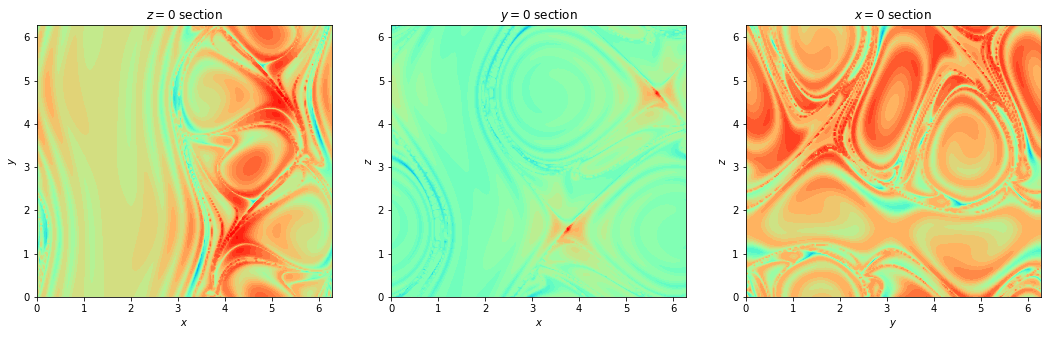

In [10]:
import matplotlib.pyplot as plt
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, TSE_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, TSE_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, TSE_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

In [ ]:
############################################ PLOT RESULTS ############################################

# Import plotly for 3D figures
from plotly import graph_objs as go

# define minimum and maximum values for colorbar
min_value = min(np.min(TSE_yz),min(np.min(TSE_xy), np.min(TSE_xz)))
max_value = max(np.max(TSE_yz),max(np.max(TSE_xy), np.max(TSE_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = TSE_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = TSE_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = TSE_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = TSE_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = TSE_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = TSE_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{TSE}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

### Plot  $\overline{\text{TSE}}$

Text(0.5, 1.0, '$x=0$ section')

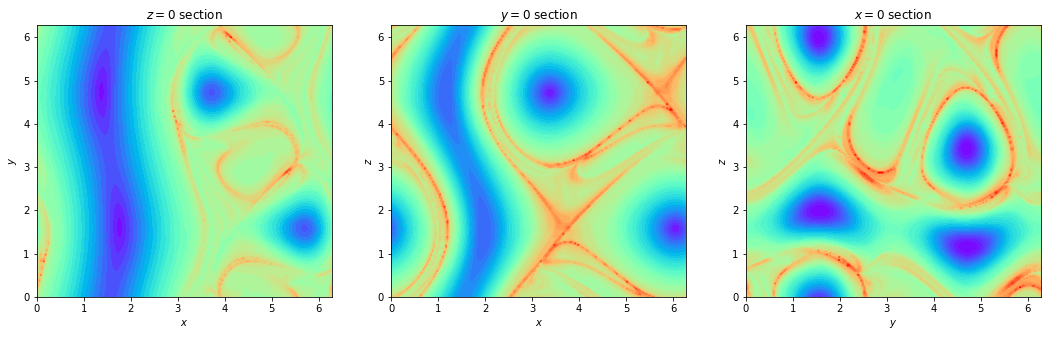

In [11]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, TSE_bar_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, TSE_bar_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, TSE_bar_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

In [ ]:
############################################ PLOT RESULTS ############################################

# Import plotly for 3D figures
from plotly import graph_objs as go

# define minimum and maximum values for colorbar
min_value = min(np.min(TSE_bar_yz),min(np.min(TSE_bar_xy), np.min(TSE_bar_xz)))
max_value = max(np.max(TSE_bar_yz),max(np.max(TSE_bar_xy), np.max(TSE_bar_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = TSE_bar_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = TSE_bar_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = TSE_bar_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = TSE_bar_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = TSE_bar_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = TSE_bar_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{\overline{{TSE}}}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

The $ \mathrm{TSE}/\mathrm{\overline{TSE}} $ highlights features similar to [FTLE](../../FTLE3D/Main/FTLEABCsteady.ipynb). In order to test the ability of the $ \mathrm{TSE}/\mathrm{\overline{TSE}} $ to extract flow features even in a sparse data setting, we randomly progressively downsample the trajectory data.

# Random subsampling

As shown in the following figures, $ \mathrm{TSE}/\mathrm{\overline{TSE}} $ is able to capture the flow features at very low resolution.

## 10% subsampling

In [12]:
# import random number generator
import random

# 10% subsampling
rdn10 = random.sample(range(0, Nx*Ny), int(Nx*Ny/10))

# Subsample initial grid and TSE_bar field (=subsample trajectories) on XY-plane
x_XY_subsampled10 = X0_xy.ravel()[rdn10] # array (Nx*Ny/10, )
y_XY_subsampled10 = Y0_xy.ravel()[rdn10] # array (Nx*Ny/10, )
TSE_bar_XY_subsampled10 = TSE_bar_xy.ravel()[rdn10] # array (Nx*Ny/10, )

# Subsample initial grid and TSE_bar field (=subsample trajectories) on XZ-plane
x_XZ_subsampled10 = X0_xz.ravel()[rdn10] # array (Nx*Ny/10, )
y_XZ_subsampled10 = Z0_xz.ravel()[rdn10] # array (Nx*Ny/10, )
TSE_bar_XZ_subsampled10 = TSE_bar_xz.ravel()[rdn10] # array (Nx*Ny/10, )

# Subsample initial grid and TRA field (=subsample trajectories) on YZ-plane
x_YZ_subsampled10 = Y0_yz.ravel()[rdn10] # array (Nx*Ny/10, )
y_YZ_subsampled10 = Z0_yz.ravel()[rdn10] # array (Nx*Ny/10, )
TSE_bar_YZ_subsampled10 = TSE_bar_yz.ravel()[rdn10] # array (Nx*Ny/10, )

# Import interpolant for scatter interpolation
from scipy.interpolate import Rbf

# Compute Interpolant
interp10_XY = Rbf(x_XY_subsampled10, y_XY_subsampled10, TSE_bar_XY_subsampled10, function = "linear")
interp10_XZ = Rbf(x_XZ_subsampled10, y_XZ_subsampled10, TSE_bar_XZ_subsampled10, function = "linear")
interp10_YZ = Rbf(x_YZ_subsampled10, y_YZ_subsampled10, TSE_bar_YZ_subsampled10, function = "linear")

# Re-evaluate interpolant over original (initial) meshgrid
TSE_bar_interpolated10_xy = interp10_XY(X0_xy, Y0_xy) 
TSE_bar_interpolated10_xz = interp10_XZ(X0_xz, Z0_xz) 
TSE_bar_interpolated10_yz = interp10_YZ(Y0_yz, Z0_yz)

In [ ]:
############################################ PLOT RESULTS ############################################

# define minimum and maximum values for colorbar
min_value = min(np.min(TSE_bar_yz),min(np.min(TSE_bar_xy), np.min(TSE_bar_xz)))
max_value = max(np.max(TSE_bar_yz),max(np.max(TSE_bar_xy), np.max(TSE_bar_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = TSE_bar_interpolated10_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = TSE_bar_interpolated10_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = TSE_bar_interpolated10_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = TSE_bar_interpolated10_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = TSE_bar_interpolated10_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = TSE_bar_interpolated10_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{\overline{{TSE}}}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Text(0.5, 1.0, '$x=0$ section')

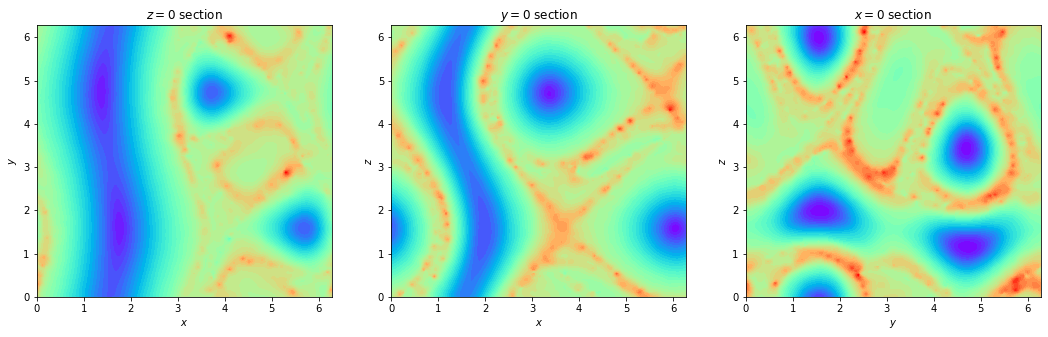

In [13]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, TSE_bar_interpolated10_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, TSE_bar_interpolated10_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, TSE_bar_interpolated10_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

## 1% subsampling

In [14]:
# 1% subsampling
rdn100 = random.sample(range(0, Nx*Ny), int(Nx*Ny/100))

# Subsample initial grid and TSE_bar field (=subsample trajectories) on XY-plane
x_XY_subsampled100 = X0_xy.ravel()[rdn100] # array (Nx*Ny/10, )
y_XY_subsampled100 = Y0_xy.ravel()[rdn100] # array (Nx*Ny/10, )
TSE_bar_XY_subsampled100 = TSE_bar_xy.ravel()[rdn100] # array (Nx*Ny/10, )

# Subsample initial grid and TSE_bar field (=subsample trajectories) on XZ-plane
x_XZ_subsampled100 = X0_xz.ravel()[rdn100] # array (Nx*Ny/10, )
y_XZ_subsampled100 = Z0_xz.ravel()[rdn100] # array (Nx*Ny/10, )
TSE_bar_XZ_subsampled100 = TSE_bar_xz.ravel()[rdn100] # array (Nx*Ny/10, )

# Subsample initial grid and TSE_bar field (=subsample trajectories) on YZ-plane
x_YZ_subsampled100 = Y0_yz.ravel()[rdn100] # array (Nx*Ny/10, )
y_YZ_subsampled100 = Z0_yz.ravel()[rdn100] # array (Nx*Ny/10, )
TSE_bar_YZ_subsampled100 = TSE_bar_yz.ravel()[rdn100] # array (Nx*Ny/10, )

# Compute Interpolant
interp100_XY = Rbf(x_XY_subsampled100, y_XY_subsampled100, TSE_bar_XY_subsampled100, function = "linear")
interp100_XZ = Rbf(x_XZ_subsampled100, y_XZ_subsampled100, TSE_bar_XZ_subsampled100, function = "linear")
interp100_YZ = Rbf(x_YZ_subsampled100, y_YZ_subsampled100, TSE_bar_YZ_subsampled100, function = "linear")

# Re-evaluate interpolant over original (initial) meshgrid
TSE_bar_interpolated100_xy = interp100_XY(X0_xy, Y0_xy) 
TSE_bar_interpolated100_xz = interp100_XZ(X0_xz, Z0_xz) 
TSE_bar_interpolated100_yz = interp100_YZ(Y0_yz, Z0_yz)

Text(0.5, 1.0, '$x=0$ section')

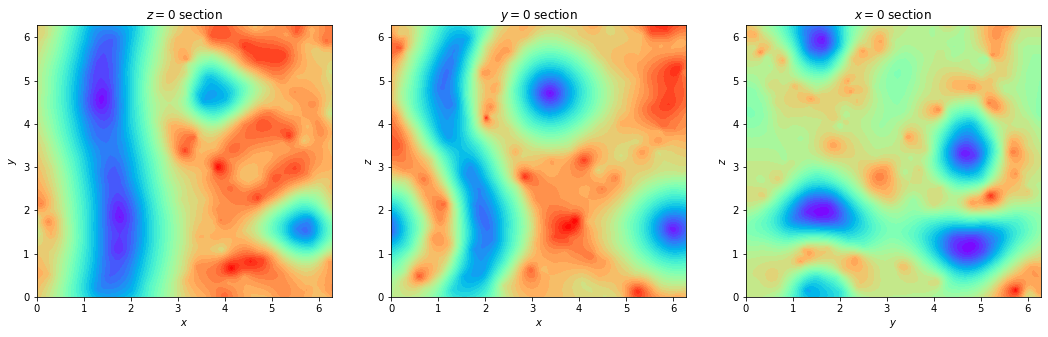

In [15]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, TSE_bar_interpolated100_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, TSE_bar_interpolated100_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, TSE_bar_interpolated100_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

In [ ]:
############################################ PLOT RESULTS ############################################

# define minimum and maximum values for colorbar
min_value = min(np.min(TSE_bar_yz),min(np.min(TSE_bar_xy), np.min(TSE_bar_xz)))
max_value = max(np.max(TSE_bar_yz),max(np.max(TSE_bar_xy), np.max(TSE_bar_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = TSE_bar_interpolated100_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = TSE_bar_interpolated100_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = TSE_bar_interpolated100_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = TSE_bar_interpolated100_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = TSE_bar_interpolated100_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = TSE_bar_interpolated100_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{\overline{{TSE}}}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

## 0.1% subsampling

In [16]:
# 0.1% subsampling
rdn1000 = random.sample(range(0, Nx*Ny), int(Nx*Ny/1000))

# Subsample initial grid and TSE_bar field (=subsample trajectories) on XY-plane
x_XY_subsampled1000 = X0_xy.ravel()[rdn1000] # array (Nx*Ny/10, )
y_XY_subsampled1000 = Y0_xy.ravel()[rdn1000] # array (Nx*Ny/10, )
TSE_bar_XY_subsampled1000 = TSE_bar_xy.ravel()[rdn1000] # array (Nx*Ny/10, )

# Subsample initial grid and TSE_bar field (=subsample trajectories) on XZ-plane
x_XZ_subsampled1000 = X0_xz.ravel()[rdn1000] # array (Nx*Ny/10, )
y_XZ_subsampled1000 = Z0_xz.ravel()[rdn1000] # array (Nx*Ny/10, )
TSE_bar_XZ_subsampled1000 = TSE_bar_xz.ravel()[rdn1000] # array (Nx*Ny/10, )

# Subsample initial grid and TSE_bar field (=subsample trajectories) on YZ-plane
x_YZ_subsampled1000 = Y0_yz.ravel()[rdn1000] # array (Nx*Ny/10, )
y_YZ_subsampled1000 = Z0_yz.ravel()[rdn1000] # array (Nx*Ny/10, )
TSE_bar_YZ_subsampled1000 = TSE_bar_yz.ravel()[rdn1000] # array (Nx*Ny/10, )

# Compute Interpolant
interp1000_XY = Rbf(x_XY_subsampled1000, y_XY_subsampled1000, TSE_bar_XY_subsampled1000, function = "linear")
interp1000_XZ = Rbf(x_XZ_subsampled1000, y_XZ_subsampled1000, TSE_bar_XZ_subsampled1000, function = "linear")
interp1000_YZ = Rbf(x_YZ_subsampled1000, y_YZ_subsampled1000, TSE_bar_YZ_subsampled1000, function = "linear")

# Re-evaluate interpolant over original (initial) meshgrid
TSE_bar_interpolated1000_xy = interp1000_XY(X0_xy, Y0_xy) 
TSE_bar_interpolated1000_xz = interp1000_XZ(X0_xz, Z0_xz) 
TSE_bar_interpolated1000_yz = interp1000_YZ(Y0_yz, Z0_yz)

Text(0.5, 1.0, '$x=0$ section')

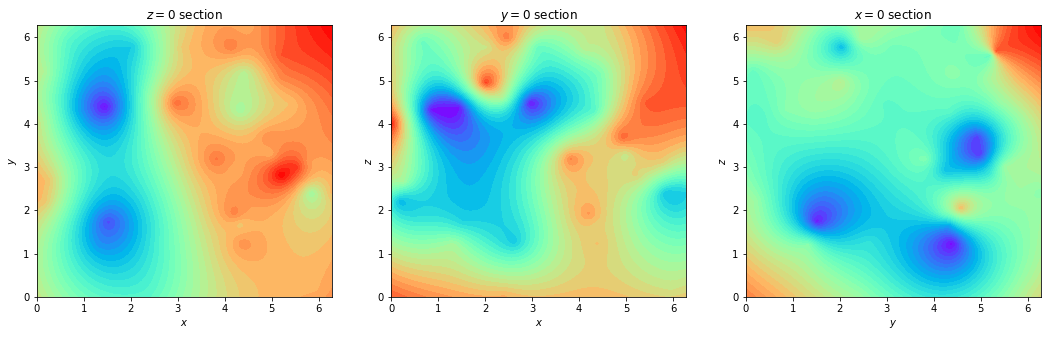

In [17]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, TSE_bar_interpolated1000_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, TSE_bar_interpolated1000_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, TSE_bar_interpolated1000_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

In [ ]:
############################################ PLOT RESULTS ############################################

# define minimum and maximum values for colorbar
min_value = min(np.min(TSE_bar_yz),min(np.min(TSE_bar_xy), np.min(TSE_bar_xz)))
max_value = max(np.max(TSE_bar_yz),max(np.max(TSE_bar_xy), np.max(TSE_bar_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = TSE_bar_interpolated1000_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = TSE_bar_interpolated1000_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = TSE_bar_interpolated1000_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = TSE_bar_interpolated1000_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = TSE_bar_interpolated1000_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = TSE_bar_interpolated100_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{\overline{{TSE}}}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

The $ \mathrm{\overline{TSE}} $ approximates hyperbolic flow features from single lagrangian particle trajectories.
Contrary to other commonly used hyperbolic LCS detection methods such as the $ \mathrm{\overline{FTLE}}$, the features of $ \mathrm{\overline{TSE}} $ are robust with respect to subsampling as the main flow features are preserved even in a very sparse setting.

# References

[1] Haller, G., Aksamit, N., & Encinas-Bartos, A. P. (2021). Quasi-objective coherent structure diagnostics from single trajectories. Chaos: An Interdisciplinary Journal of Nonlinear Science, 31(4), 043131.

[2] Notebook 5.5.2 in "Transport Barriers and Coherent Structures in Flow Data" by George Haller